# LTE SRS correlation tester notebook

This notebook mirrors the functionality of `srs_tester.py` and showcases how to generate Sounding Reference Signals (SRS) for multiple user configurations, compute normalized cross-correlations, and optionally visualize the results.

In [12]:

!git clone https://github.com/Amihay11/srs_creator.git

Cloning into 'srs_creator'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 15.45 KiB | 7.72 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [20]:
!ls


sample_data  srs_creator


In [25]:
import itertools
from dataclasses import dataclass
from typing import Iterable, List, Tuple

import importlib.util
import numpy as np
import sys

# Add the srs_creator directory to Python's path
sys.path.append('./srs_creator')

from lte_srs import (
    MappingInfo,
    SRSConfig,
    generate_srs,
    normalized_cross_correlation,
)


@dataclass
class SRSResult:
    signal: np.ndarray
    info: MappingInfo


def build_configurations() -> List[SRSConfig]:
    """Create a small suite of diverse SRS configurations for testing."""

    common = dict(bandwidth_config=2, subframe_config=2, b_hop=1, n_ul_rb=50)
    return [
        SRSConfig(
            cell_id=cell,
            group_hopping_enabled=gh,
            sequence_hopping_enabled=sh,
            transmission_comb=comb,
            cyclic_shift=alpha,
            srs_bandwidth=n_b,
            **common,
        )
        for cell, gh, sh, comb, alpha, n_b in [
            (0, True, False, 0, 0.0, 0),
            (1, True, True, 1, np.pi / 4, 1),
            (12, False, True, 0, np.pi / 2, 2),
            (37, False, False, 1, 3 * np.pi / 4, 3),
        ]
    ]


def generate_signals(configs: Iterable[SRSConfig], subframe: int) -> List[SRSResult]:
    results: List[SRSResult] = []
    for cfg in configs:
        sig, info = generate_srs(cfg, subframe)
        results.append(SRSResult(signal=sig, info=info))
    return results


def correlation_matrix(results: List[SRSResult]) -> np.ndarray:
    """Compute the normalized correlation matrix for a set of signals."""

    n = len(results)
    corr = np.zeros((n, n))
    for i, j in itertools.product(range(n), repeat=2):
        corr[i, j] = normalized_cross_correlation(results[i].signal, results[j].signal)
    return corr


def highlight_pairs(corr: np.ndarray, threshold: float = 0.3) -> List[Tuple[int, int, float]]:
    """Return pairs with correlation magnitude above a threshold."""

    pairs: List[Tuple[int, int, float]] = []
    n = corr.shape[0]
    for i in range(n):
        for j in range(i + 1, n):
            if corr[i, j] > threshold:
                pairs.append((i, j, corr[i, j]))
    return pairs


def plot_correlation(corr: np.ndarray, labels: List[str], path: str = "correlation_matrix.png") -> str:
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(corr, vmin=0, vmax=1, cmap="viridis")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_title("Normalized SRS Cross-Correlation")
    fig.colorbar(im, ax=ax, label="|corr|")
    fig.tight_layout()
    fig.savefig(path, dpi=150)
    plt.close(fig)
    return path


def has_matplotlib() -> bool:
    return importlib.util.find_spec("matplotlib") is not None


print("Helper utilities loaded.")

Helper utilities loaded.


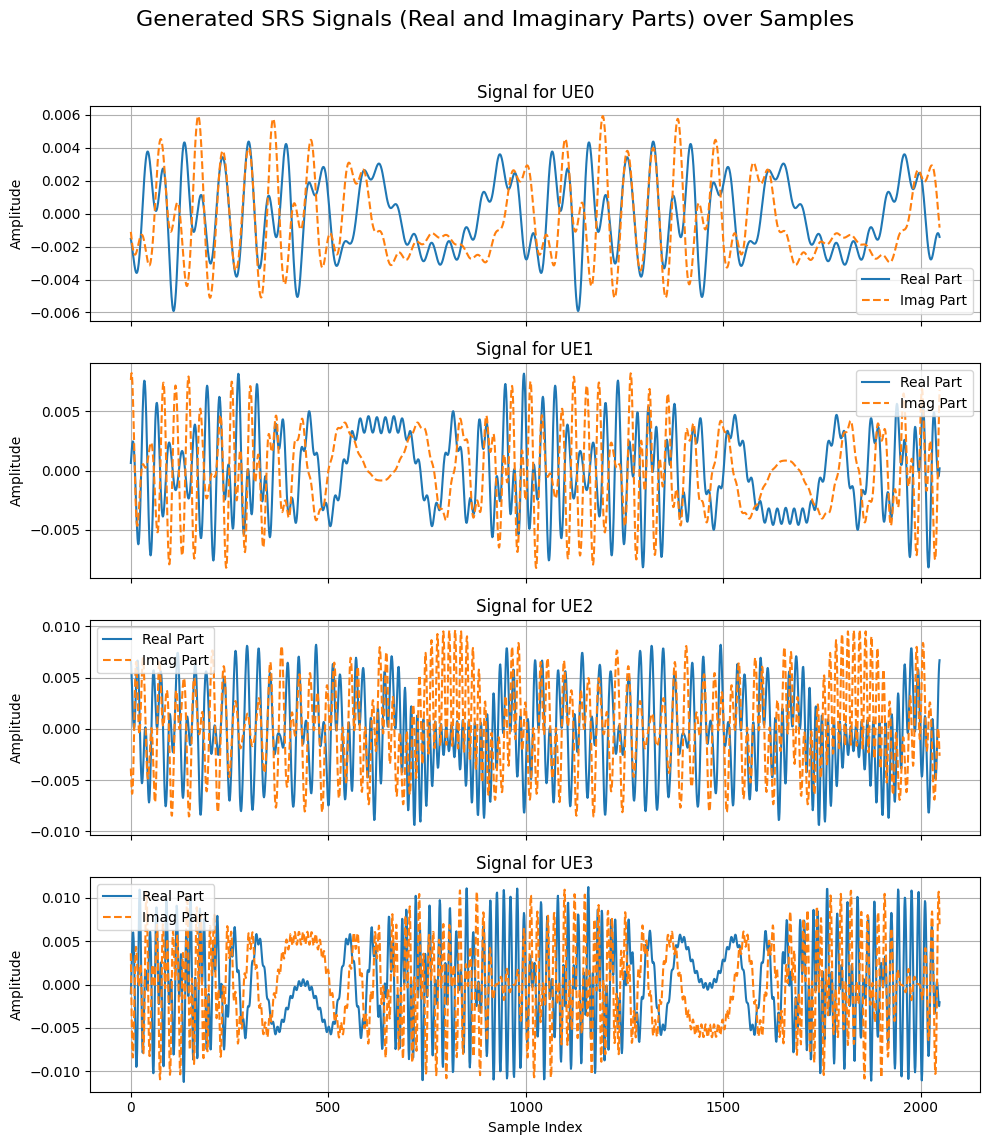

In [27]:
import matplotlib.pyplot as plt

# Plotting individual SRS signals
fig, axes = plt.subplots(len(results), 1, figsize=(10, 3 * len(results)), sharex=True)
fig.suptitle('Generated SRS Signals (Real and Imaginary Parts) over Samples', fontsize=16)

for i, (res, label) in enumerate(zip(results, labels)):
    signal = res.signal
    ax = axes[i]
    ax.plot(np.real(signal), label='Real Part')
    ax.plot(np.imag(signal), label='Imag Part', linestyle='--')
    ax.set_title(f'Signal for {label}')
    ax.set_ylabel('Amplitude')
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel('Sample Index')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [22]:
# Example execution
configs = build_configurations()
subframe = 4
print(f"Generating SRS for subframe {subframe}\n")
for cfg in configs:
    print(cfg)

results = generate_signals(configs, subframe)
labels = [f"UE{i}" for i in range(len(results))]
corr = correlation_matrix(results)
pairs = highlight_pairs(corr)

print("\nCorrelation matrix (magnitude):")
with np.printoptions(precision=3, suppress=True):
    print(corr)

if pairs:
    print("\nHighly correlated pairs (>0.3):")
    for i, j, v in pairs:
        print(f"  {labels[i]} vs {labels[j]}: {v:.3f}")
else:
    print("\nNo highly correlated pairs detected.")

if has_matplotlib():
    plot_path = plot_correlation(corr, labels)
    print(f"Correlation heatmap saved to {plot_path}")
else:
    print("Matplotlib is not available; skipping heatmap rendering.")


Generating SRS for subframe 4

SRSConfig(cell_id=0, bandwidth_config=2, subframe_config=2, b_hop=1, group_hopping_enabled=True, sequence_hopping_enabled=False, transmission_comb=0, cyclic_shift=0.0, srs_bandwidth=0, n_ul_rb=50, n_zc=None)
SRSConfig(cell_id=1, bandwidth_config=2, subframe_config=2, b_hop=1, group_hopping_enabled=True, sequence_hopping_enabled=True, transmission_comb=1, cyclic_shift=0.7853981633974483, srs_bandwidth=1, n_ul_rb=50, n_zc=None)
SRSConfig(cell_id=12, bandwidth_config=2, subframe_config=2, b_hop=1, group_hopping_enabled=False, sequence_hopping_enabled=True, transmission_comb=0, cyclic_shift=1.5707963267948966, srs_bandwidth=2, n_ul_rb=50, n_zc=None)
SRSConfig(cell_id=37, bandwidth_config=2, subframe_config=2, b_hop=1, group_hopping_enabled=False, sequence_hopping_enabled=False, transmission_comb=1, cyclic_shift=2.356194490192345, srs_bandwidth=3, n_ul_rb=50, n_zc=None)

Correlation matrix (magnitude):
[[1.    0.    0.085 0.   ]
 [0.    1.    0.    0.089]
 [0.

(np.float64(-0.5), np.float64(899.5), np.float64(749.5), np.float64(-0.5))

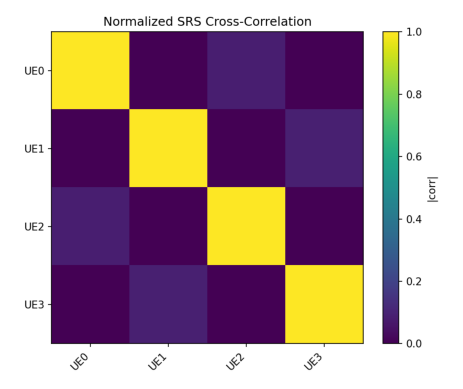

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('correlation_matrix.png')
plt.imshow(img)
plt.axis('off')



# Task
Analyze the temporal similarity of the generated SRS signals (`results`) by implementing and applying a time-varying cross-correlation function to their pairs, visualizing the results through plots, and summarizing the insights gained.

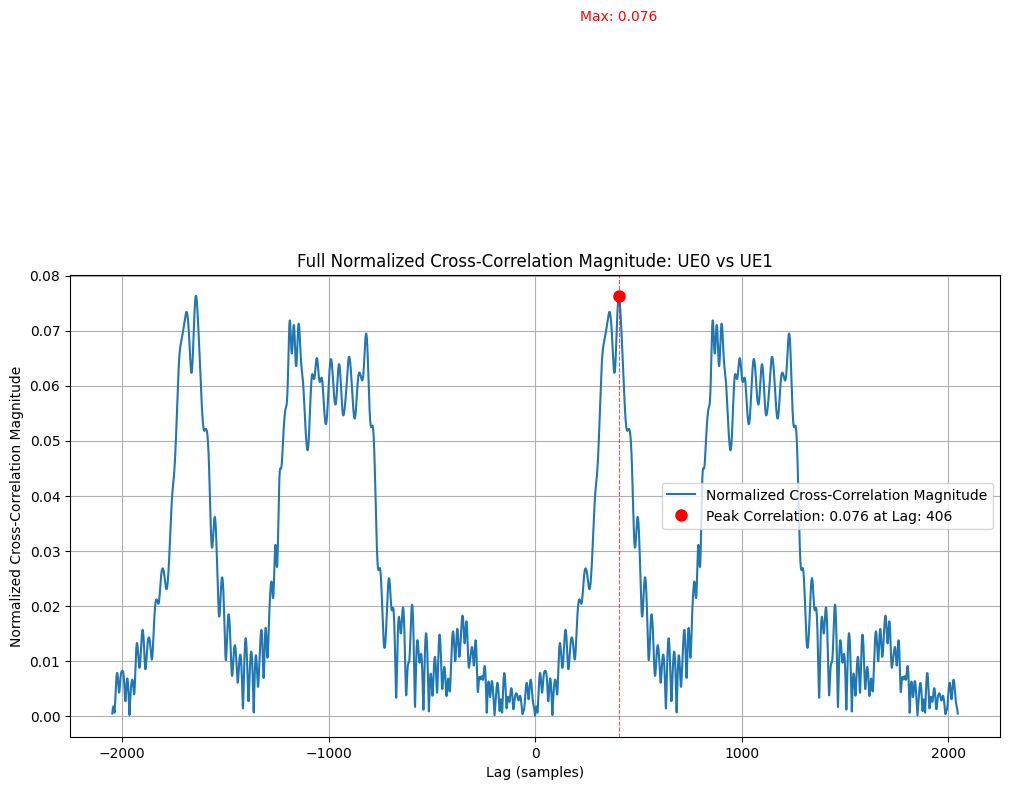

Plotted full normalized cross-correlation for UE0 and UE1.
The peak cross-correlation magnitude is 0.076 at a lag of 406.


In [36]:
import matplotlib.pyplot as plt

# Select a pair of signals for demonstration (e.g., UE0 and UE1)
signal_idx1 = 0
signal_idx2 = 1

s1 = results[signal_idx1].signal
s2 = results[signal_idx2].signal
label1 = labels[signal_idx1]
label2 = labels[signal_idx2]

# Compute full normalized cross-correlation
correlation_sequence, lags = full_normalized_cross_correlation(s1, s2)

# Find the peak correlation magnitude and its corresponding lag
abs_correlation_sequence = np.abs(correlation_sequence)
peak_corr_magnitude = np.max(abs_correlation_sequence)
peak_lag_idx = np.argmax(abs_correlation_sequence)
peak_lag = lags[peak_lag_idx]

# Plot the full cross-correlation sequence
plt.figure(figsize=(12, 6))
plt.plot(lags, abs_correlation_sequence, label='Normalized Cross-Correlation Magnitude')

# Highlight the peak
plt.plot(peak_lag, peak_corr_magnitude, 'ro', markersize=8, label=f'Peak Correlation: {peak_corr_magnitude:.3f} at Lag: {peak_lag}')
plt.axvline(peak_lag, color='r', linestyle='--', linewidth=0.8, alpha=0.7)
plt.text(peak_lag, peak_corr_magnitude + 0.05, f'Max: {peak_corr_magnitude:.3f}', color='red', ha='center')

plt.title(f'Full Normalized Cross-Correlation Magnitude: {label1} vs {label2}')
plt.xlabel('Lag (samples)')
plt.ylabel('Normalized Cross-Correlation Magnitude')
plt.grid(True)
plt.legend()
plt.show()

print(f"Plotted full normalized cross-correlation for {label1} and {label2}.")
print(f"The peak cross-correlation magnitude is {peak_corr_magnitude:.3f} at a lag of {peak_lag}.")

In [37]:
def full_normalized_cross_correlation(signal1: np.ndarray, signal2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the full normalized cross-correlation between two 1D signals.
    Similar to MATLAB's xcorr(a, b, 'coeff').

    Args:
        signal1 (np.ndarray): The first input signal.
        signal2 (np.ndarray): The second input signal.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - correlation_values (np.ndarray): The normalized cross-correlation sequence.
            - lags (np.ndarray): The corresponding lag values.
    """
    # Ensure signals are complex for complex correlation
    s1 = signal1.astype(np.complex128)
    s2 = signal2.astype(np.complex128)

    # Compute the raw cross-correlation
    # 'full' mode returns correlation for all possible lags
    raw_correlation = np.correlate(s1, s2, mode='full')

    # Normalize by the product of the L2 norms of the signals.
    # This gives a maximum correlation of 1 for identical signals when perfectly aligned.
    norm_factor = np.sqrt(np.sum(np.abs(s1)**2) * np.sum(np.abs(s2)**2))
    if norm_factor == 0:
        normalized_correlation = np.zeros_like(raw_correlation)
    else:
        normalized_correlation = raw_correlation / norm_factor

    # Calculate lags
    len_s1 = len(s1)
    len_s2 = len(s2)
    lags = np.arange(-(len_s2 - 1), len_s1)

    return normalized_correlation, lags

print("Function 'full_normalized_cross_correlation' defined.")

Function 'full_normalized_cross_correlation' defined.


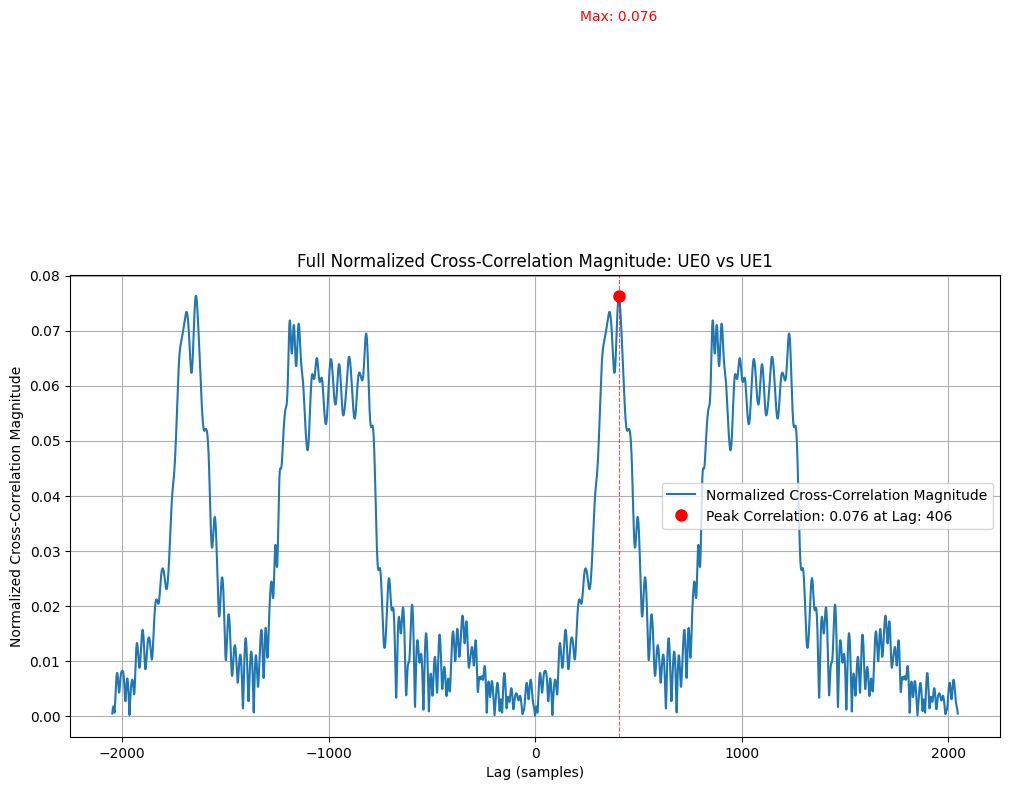

Plotted full normalized cross-correlation for UE0 and UE1.
The peak cross-correlation magnitude is 0.076 at a lag of 406.


In [39]:
import matplotlib.pyplot as plt

# Select a pair of signals for demonstration (e.g., UE0 and UE1)
signal_idx1 = 0
signal_idx2 = 1

s1 = results[signal_idx1].signal
s2 = results[signal_idx2].signal
label1 = labels[signal_idx1]
label2 = labels[signal_idx2]

# Compute full normalized cross-correlation
correlation_sequence, lags = full_normalized_cross_correlation(s1, s2)

# Find the peak correlation magnitude and its corresponding lag
abs_correlation_sequence = np.abs(correlation_sequence)
peak_corr_magnitude = np.max(abs_correlation_sequence)
peak_lag_idx = np.argmax(abs_correlation_sequence)
peak_lag = lags[peak_lag_idx]

# Plot the full cross-correlation sequence
plt.figure(figsize=(12, 6))
plt.plot(lags, abs_correlation_sequence, label='Normalized Cross-Correlation Magnitude')

# Highlight the peak
plt.plot(peak_lag, peak_corr_magnitude, 'ro', markersize=8, label=f'Peak Correlation: {peak_corr_magnitude:.3f} at Lag: {peak_lag}')
plt.axvline(peak_lag, color='r', linestyle='--', linewidth=0.8, alpha=0.7)
plt.text(peak_lag, peak_corr_magnitude + 0.05, f'Max: {peak_corr_magnitude:.3f}', color='red', ha='center')

plt.title(f'Full Normalized Cross-Correlation Magnitude: {label1} vs {label2}')
plt.xlabel('Lag (samples)')
plt.ylabel('Normalized Cross-Correlation Magnitude')
plt.grid(True)
plt.legend()
plt.show()

print(f"Plotted full normalized cross-correlation for {label1} and {label2}.")
print(f"The peak cross-correlation magnitude is {peak_corr_magnitude:.3f} at a lag of {peak_lag}.")

### Auto-Correlation of a Single SRS Signal

To demonstrate what a strong, distinguishable cross-correlation peak looks like, we compute the auto-correlation of one of the SRS signals (UE0). Auto-correlation is the cross-correlation of a signal with itself, and it should yield a prominent peak where the signal perfectly aligns with its shifted self.

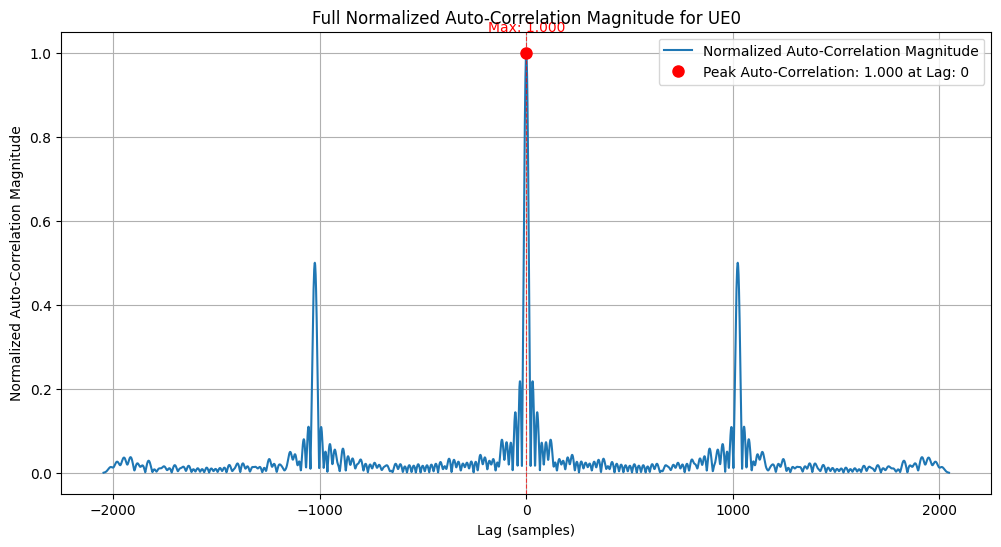

Plotted full normalized auto-correlation for UE0.
The peak auto-correlation magnitude is 1.000 at a lag of 0.


In [41]:
import matplotlib.pyplot as plt

# Select one signal for auto-correlation (e.g., UE0)
signal_idx = 0
signal_for_auto_corr = results[signal_idx].signal
label_for_auto_corr = labels[signal_idx]

# Compute full normalized auto-correlation (signal correlated with itself)
auto_correlation_sequence, auto_lags = full_normalized_cross_correlation(signal_for_auto_corr, signal_for_auto_corr)

# Find the peak auto-correlation magnitude and its corresponding lag
abs_auto_correlation_sequence = np.abs(auto_correlation_sequence)
peak_auto_corr_magnitude = np.max(abs_auto_correlation_sequence)
peak_auto_lag_idx = np.argmax(abs_auto_correlation_sequence)
peak_auto_lag = auto_lags[peak_auto_lag_idx]

# Plot the full auto-correlation sequence
plt.figure(figsize=(12, 6))
plt.plot(auto_lags, abs_auto_correlation_sequence, label='Normalized Auto-Correlation Magnitude')

# Highlight the peak
plt.plot(peak_auto_lag, peak_auto_corr_magnitude, 'ro', markersize=8, label=f'Peak Auto-Correlation: {peak_auto_corr_magnitude:.3f} at Lag: {peak_auto_lag}')
plt.axvline(peak_auto_lag, color='r', linestyle='--', linewidth=0.8, alpha=0.7)
plt.text(peak_auto_lag, peak_auto_corr_magnitude + 0.05, f'Max: {peak_auto_corr_magnitude:.3f}', color='red', ha='center')

plt.title(f'Full Normalized Auto-Correlation Magnitude for {label_for_auto_corr}')
plt.xlabel('Lag (samples)')
plt.ylabel('Normalized Auto-Correlation Magnitude')
plt.grid(True)
plt.legend()
plt.show()

print(f"Plotted full normalized auto-correlation for {label_for_auto_corr}.")
print(f"The peak auto-correlation magnitude is {peak_auto_corr_magnitude:.3f} at a lag of {peak_auto_lag}.")

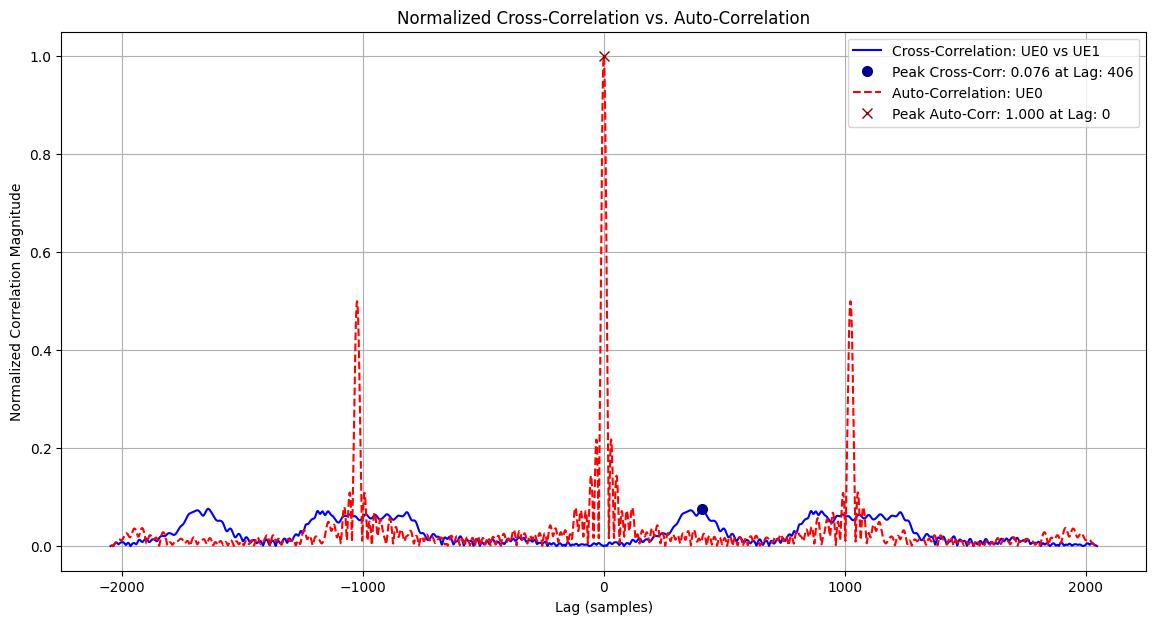

Combined plot of cross-correlation and auto-correlation generated.


In [43]:
import matplotlib.pyplot as plt

# --- Data for Cross-Correlation (UE0 vs UE1) ---
# These variables should already be available from previous execution if new_cell_plot_xcorr was run.
# signal_idx1 = 0; signal_idx2 = 1
# s1 = results[signal_idx1].signal; s2 = results[signal_idx2].signal
# label1 = labels[signal_idx1]; label2 = labels[signal_idx2]
# correlation_sequence, lags = full_normalized_cross_correlation(s1, s2)
# abs_correlation_sequence = np.abs(correlation_sequence)
# peak_corr_magnitude = np.max(abs_correlation_sequence)
# peak_lag = lags[np.argmax(abs_correlation_sequence)]

# --- Data for Auto-Correlation (UE0 vs UE0) ---
# These variables should already be available from previous execution if new_cell_auto_corr_plot was run.
# signal_idx = 0
# signal_for_auto_corr = results[signal_idx].signal
# label_for_auto_corr = labels[signal_idx]
# auto_correlation_sequence, auto_lags = full_normalized_cross_correlation(signal_for_auto_corr, signal_for_auto_corr)
# abs_auto_correlation_sequence = np.abs(auto_correlation_sequence)
# peak_auto_corr_magnitude = np.max(abs_auto_correlation_sequence)
# peak_auto_lag = auto_lags[np.argmax(abs_auto_correlation_sequence)]

# Ensure all necessary variables are defined (re-run previous cells if needed)
if 'abs_correlation_sequence' not in locals():
    print("Re-computing cross-correlation data...")
    signal_idx1 = 0
    signal_idx2 = 1
    s1 = results[signal_idx1].signal
    s2 = results[signal_idx2].signal
    label1 = labels[signal_idx1]
    label2 = labels[signal_idx2]
    correlation_sequence, lags = full_normalized_cross_correlation(s1, s2)
    abs_correlation_sequence = np.abs(correlation_sequence)
    peak_corr_magnitude = np.max(abs_correlation_sequence)
    peak_lag = lags[np.argmax(abs_correlation_sequence)]

if 'abs_auto_correlation_sequence' not in locals():
    print("Re-computing auto-correlation data...")
    signal_idx = 0
    signal_for_auto_corr = results[signal_idx].signal
    label_for_auto_corr = labels[signal_idx]
    auto_correlation_sequence, auto_lags = full_normalized_cross_correlation(signal_for_auto_corr, signal_for_auto_corr)
    abs_auto_correlation_sequence = np.abs(auto_correlation_sequence)
    peak_auto_corr_magnitude = np.max(abs_auto_correlation_sequence)
    peak_auto_lag = auto_lags[np.argmax(abs_auto_correlation_sequence)]

# --- Plotting ---
plt.figure(figsize=(14, 7))

# Plot Cross-Correlation
plt.plot(lags, abs_correlation_sequence, label=f'Cross-Correlation: {label1} vs {label2}', color='blue')
plt.plot(peak_lag, peak_corr_magnitude, 'o', color='darkblue', markersize=7, label=f'Peak Cross-Corr: {peak_corr_magnitude:.3f} at Lag: {peak_lag}')

# Plot Auto-Correlation
plt.plot(auto_lags, abs_auto_correlation_sequence, label=f'Auto-Correlation: {label_for_auto_corr}', color='red', linestyle='--')
plt.plot(peak_auto_lag, peak_auto_corr_magnitude, 'x', color='darkred', markersize=7, label=f'Peak Auto-Corr: {peak_auto_corr_magnitude:.3f} at Lag: {peak_auto_lag}')

plt.title('Normalized Cross-Correlation vs. Auto-Correlation')
plt.xlabel('Lag (samples)')
plt.ylabel('Normalized Correlation Magnitude')
plt.grid(True)
plt.legend()
plt.show()

print("Combined plot of cross-correlation and auto-correlation generated.")

In [44]:
import plotly.graph_objects as go
import numpy as np

# Ensure all necessary variables are defined (re-run previous cells if needed)
if 'abs_correlation_sequence' not in locals():
    print("Re-computing cross-correlation data for interactive plot...")
    signal_idx1 = 0
    signal_idx2 = 1
    s1 = results[signal_idx1].signal
    s2 = results[signal_idx2].signal
    label1 = labels[signal_idx1]
    label2 = labels[signal_idx2]
    correlation_sequence, lags = full_normalized_cross_correlation(s1, s2)
    abs_correlation_sequence = np.abs(correlation_sequence)
    peak_corr_magnitude = np.max(abs_correlation_sequence)
    peak_lag = lags[np.argmax(abs_correlation_sequence)]

if 'abs_auto_correlation_sequence' not in locals():
    print("Re-computing auto-correlation data for interactive plot...")
    signal_idx = 0
    signal_for_auto_corr = results[signal_idx].signal
    label_for_auto_corr = labels[signal_idx]
    auto_correlation_sequence, auto_lags = full_normalized_cross_correlation(signal_for_auto_corr, signal_for_auto_corr)
    abs_auto_correlation_sequence = np.abs(auto_correlation_sequence)
    peak_auto_corr_magnitude = np.max(abs_auto_correlation_sequence)
    peak_auto_lag = auto_lags[np.argmax(abs_auto_correlation_sequence)]

# Create Plotly figure
fig = go.Figure()

# Add Cross-Correlation trace
fig.add_trace(go.Scatter(
    x=lags,
    y=abs_correlation_sequence,
    mode='lines',
    name=f'Cross-Correlation: {label1} vs {label2}',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=[peak_lag],
    y=[peak_corr_magnitude],
    mode='markers',
    marker=dict(color='darkblue', size=10, symbol='circle'),
    name=f'Peak Cross-Corr: {peak_corr_magnitude:.3f} at Lag: {peak_lag}',
    hoverinfo='name+x+y'
))

# Add Auto-Correlation trace
fig.add_trace(go.Scatter(
    x=auto_lags,
    y=abs_auto_correlation_sequence,
    mode='lines',
    name=f'Auto-Correlation: {label_for_auto_corr}',
    line=dict(color='red', dash='dash')
))
fig.add_trace(go.Scatter(
    x=[peak_auto_lag],
    y=[peak_auto_corr_magnitude],
    mode='markers',
    marker=dict(color='darkred', size=10, symbol='x'),
    name=f'Peak Auto-Corr: {peak_auto_corr_magnitude:.3f} at Lag: {peak_auto_lag}',
    hoverinfo='name+x+y'
))

# Update layout
fig.update_layout(
    title='Normalized Cross-Correlation vs. Auto-Correlation (Interactive)',
    xaxis_title='Lag (samples)',
    yaxis_title='Normalized Correlation Magnitude',
    hovermode='x unified'
)
fig.show()

print("Interactive combined plot of cross-correlation and auto-correlation generated.")

Interactive combined plot of cross-correlation and auto-correlation generated.
